# Variational Autoencoder (VAE)
I built a VAE for generating flower images.


In [1]:
# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import layers, models, metrics, losses
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose, Lambda, Cropping2D
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# check whether GPU is avaiable to use
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
!nvidia-smi

Num GPUs Available:  0
/bin/bash: line 1: nvidia-smi: command not found


## 1. Dataset Preparation

## To Run in Google Colab

In [3]:
import zipfile
import os

from google.colab import drive
drive.mount('/content/drive')

# List MyDrive before t
!ls /content/drive/MyDrive/



# Open dataset from zipfile
zip_path = "/content/drive/MyDrive/flowers.zip"
extract_path = '/content/drive/MyDrive/'

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset unzipped successfully!")



# lists all files in Google Drive
!ls /content/drive/MyDrive/

Mounted at /content/drive
flowers.zip  VAE.ipynb	WGAN.ipynb
Dataset unzipped successfully!
flowers_train_validation  flowers.zip  VAE.ipynb  WGAN.ipynb


## Run on Local Machine

In [4]:
'''

import os
import zipfile

# Define the paths for the zip file and extraction directory
zip_path = r"C:\path\to\your\flowers.zip"  # Update this to your zip file's actual path
extract_path = r"C:\path\to\extract\directory"  # Update this to your desired extraction directory

# Ensure the extraction path exists
os.makedirs(extract_path, exist_ok=True)

# Extract the zip file
try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Dataset unzipped successfully!")
except FileNotFoundError:
    print(f"Error: The file {zip_path} does not exist.")
except zipfile.BadZipFile:
    print(f"Error: The file {zip_path} is not a valid zip file.")

'''


'\n\nimport os\nimport zipfile\n\n# Define the paths for the zip file and extraction directory\nzip_path = r"C:\\path\to\\your\x0clowers.zip"  # Update this to your zip file\'s actual path\nextract_path = r"C:\\path\to\\extract\\directory"  # Update this to your desired extraction directory\n\n# Ensure the extraction path exists\nos.makedirs(extract_path, exist_ok=True)\n\n# Extract the zip file\ntry:\n    with zipfile.ZipFile(zip_path, \'r\') as zip_ref:\n        zip_ref.extractall(extract_path)\n    print("Dataset unzipped successfully!")\nexcept FileNotFoundError:\n    print(f"Error: The file {zip_path} does not exist.")\nexcept zipfile.BadZipFile:\n    print(f"Error: The file {zip_path} is not a valid zip file.")\n\n'

In [5]:
# Google CoLab
train_dir  = '/content/drive/MyDrive/flowers_train_validation'

# Local Machine
#train_dir = 'C:/path to local drive for extracted files /flowers_train_validation'
TARGET_SIZE=(150,150)

### 1.2: Data Preprocessing

#### 1.2.1 Using image_dataset_from_directory for constructing training dataset

**Read image_dataset_from_directory**:

- Set the image_size to be (64, 64).
- Set the batch_size to be 128.
- Modify other arguments if necessary.

In [6]:
# Load the train data
# We only use training dataset to build our VAE model
train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    color_mode= "rgb",
    image_size= (64,64),
    batch_size=128,
    labels=None,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

print(type(train_data))

Found 4323 files belonging to 1 classes.
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


### 1.2: Data Preprocessing

#### 1.2.2 Preprocessing images

**Preprocessing image**

Preprocess the imput image so that it is normalized into the value between (0, 1) *i.e.*, divided by 255.0, and then return the normalized image back.

In [7]:
# Preprocess the data
def preprocess(img):
    img = tf.cast(img, tf.float32) / 255.0
    return img

In [8]:
# the training dataset has been processed for model training
train_data = train_data.map(lambda x: preprocess(x))

### 1.3 Checking train data

**Note**: If all the above steps are set correctly, you should be able  to see the images read frm training data.

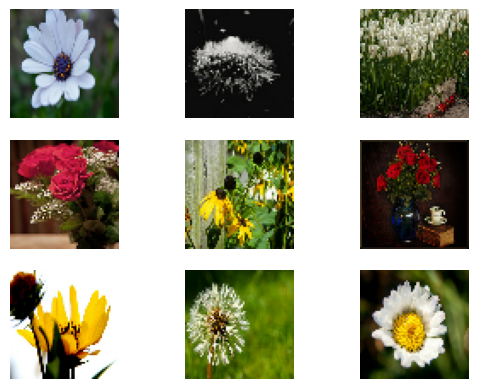

In [9]:
import matplotlib.pyplot as plt

# Take one batch from the dataset
for batch in train_data.take(1):
    # Iterate through images in the batch
    for i in range(9):  # Show 9 images for preview
        plt.subplot(3, 3, i + 1)
        plt.imshow(batch[i].numpy().clip(0, 1))  # Clip values to [0, 1] range
        plt.axis('off')
    plt.show()


## 2. Define the VAE Model

### 2.1 Sampling


**Define sampling class**

I built the `Sampling` class. This will be a custom Keras layer that will provide the Gaussian noise input along with the mean (mu) and standard deviation (sigma) of the encoder's output. In practice, the output of this layer is given by the equation:

$$z = \mu + e^{0.5\sigma} * \epsilon  $$

where $\mu$ = mean, $\sigma$ = logrithm of variance, and $\epsilon$ = random sample

In [10]:
class Sampling(tf.keras.layers.Layer):
  def call(self, inputs):
    """Generates a random sample and combines with the encoder output

    Args:
      inputs -- output tensor from the encoder

    Returns:
      tensor combined with a random sample
    """

    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon


### 2.2 The encoder

**Encoder**:

Define your encoder that compresses the input image to a lower-dimensional latent representation.
 - It uses Convolutional layers to reduce the spatial dimensions and a Flatten layer to create a latent vector.
 - The outputs are the mean and log variance vectors of the latent space.
 - Suggested Latent Space **dimension = 50**




In [11]:

"""
## Step 4: Define the Encoder
The encoder compresses the input image to a lower-dimensional latent representation.
It uses Convolutional layers to reduce the spatial dimensions and a Flatten layer to create a latent vector.
The outputs are the mean and log variance vectors of the latent space.
"""
Z_DIM = 50
IMAGE_SIZE = 64
CHANNELS = 3
NUM_FEATURES = 64

encoder_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input")
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(encoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

for _ in range(3):
    x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)
z_mean = layers.Dense(Z_DIM, name="z_mean")(x)
z_log_var = layers.Dense(Z_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           1792      ['encoder_input[0][0]']       
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)           0         ['batch_normalization[0]

## 2.2 The decoder

**Decoder**:

- **Mirror the Encoder Architecture**. If the encoder uses convolutional layers, the decoder generally uses transposed convolutional layers (Conv2DTranspose).
- **Activation Functions**. The final layer should use an activation function that matches the data characteristics, i.e., Sigmoid for pixel values in the range [0, 1]. Intermediate layers can use ReLU or LeakyReLU.
- **Final Output Layer**: In general, you should have the same number of channels and spatial dimensions as the original input image i.e., **(64, 64 ,3)*


In [12]:
# Cell 5: Define the Decoder
"""
## Step 5: Define the Decoder
The decoder reconstructs the original image from the latent representation.
It uses Dense and Conv2DTranspose layers to upsample and reshape the latent vector back to the original image shape.
"""

# Define the input for the decoder model, starting from the latent space
decoder_input = layers.Input(shape=(Z_DIM,), name="decoder_input")

# Fully connected layer to expand from the latent space to a larger dimension
x = layers.Dense(units=8192)(decoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

# Reshape to match the shape before flattening in the encoder
x = layers.Reshape((8, 8, 128))(x)

# Apply Conv2DTranspose layers to reconstruct the spatial dimensions
x = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

# Final Conv2DTranspose to match original image channels
decoder_output = layers.Conv2DTranspose(CHANNELS, kernel_size=3, strides=1, padding="same", activation="sigmoid")(x)

# Build the decoder model
decoder = models.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 50)]              0         
                                                                 
 dense (Dense)               (None, 8192)              417792    
                                                                 
 batch_normalization_4 (Bat  (None, 8192)              32768     
 chNormalization)                                                
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 64)        73792     
 anspose)                                                  

## 2.3 Autoencoder

**VAE**:

- *train_step*:
  - For the reconstruction_loss: you may try multiply **10,000 or 15,000** by losses.MeanSquaredError()(data, reconstruction), because we calculate mean square error for 64X64X3=12288 pixels, so the total error is rougly 10,000 or 15,000.


In [13]:
"""
## Step 6: Define the VAE Class
The VAE class integrates the encoder, decoder, and sampling function.
The custom `train_step()` method handles forward pass and loss calculation.
"""
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Forward pass through the encoder and decoder."""
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Defines a single training step for the VAE."""
        with tf.GradientTape() as tape:
            # Forward pass through encoder to get latent variables
            z_mean, z_log_var, z = self.encoder(data)
            # Reconstruct input data
            reconstruction = self.decoder(z)

            # Reconstruction loss with scaling factor
            reconstruction_loss = 15000 * losses.MeanSquaredError()(data, reconstruction)

            # KL divergence loss for regularization
            kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
            kl_loss = tf.reduce_mean(kl_loss)

            # Total loss as sum of reconstruction and KL divergence losses
            total_loss = reconstruction_loss + kl_loss

        # Compute gradients and apply them
        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        # Update the loss metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

## 3. Compile and Train the model

**Create a VAE model instance and Compile**:

-  Created an instance of the VAE class using the encoder and decoder models defined earlier.
- Compiled it using the Adam optimizer.

In [14]:
# Create a VAE model instance and Compile

vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())

**Model fit**:

I used the **train_data** from Section 1.2.3, set epochs to **500**.

In [15]:

"""
## Step 8: Train the VAE
We'll train the VAE using the dataset defined earlier.
"""

# Computer could not run 500 epochs so I set it to 100 even at the highest settings.
vae.fit(train_data, epochs=100)

Epoch 1/100
34/34 [==============================] - 11s 187ms/step - total_loss: 1215.3922 - reconstruction_loss: 1207.3623 - kl_loss: 8.0299
Epoch 2/100
34/34 [==============================] - 7s 178ms/step - total_loss: 823.3438 - reconstruction_loss: 794.1960 - kl_loss: 29.1476
Epoch 3/100
34/34 [==============================] - 8s 177ms/step - total_loss: 715.9849 - reconstruction_loss: 675.9340 - kl_loss: 40.0511
Epoch 4/100
34/34 [==============================] - 8s 204ms/step - total_loss: 669.8062 - reconstruction_loss: 624.4633 - kl_loss: 45.3429
Epoch 5/100
34/34 [==============================] - 7s 179ms/step - total_loss: 621.1080 - reconstruction_loss: 570.3306 - kl_loss: 50.7774
Epoch 6/100
34/34 [==============================] - 7s 173ms/step - total_loss: 570.9487 - reconstruction_loss: 515.3327 - kl_loss: 55.6160
Epoch 7/100
34/34 [==============================] - 8s 185ms/step - total_loss: 543.9032 - reconstruction_loss: 483.8792 - kl_loss: 60.0240
Epoch 8/100

## 4. Reconstruct using the variational autoencoder

In [16]:
def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

**Reconstruct images:**
- Selected  the first subset of the training set
- Created autoencoder predictions and display

4/4 [==============================] - 0s 11ms/step
real Images


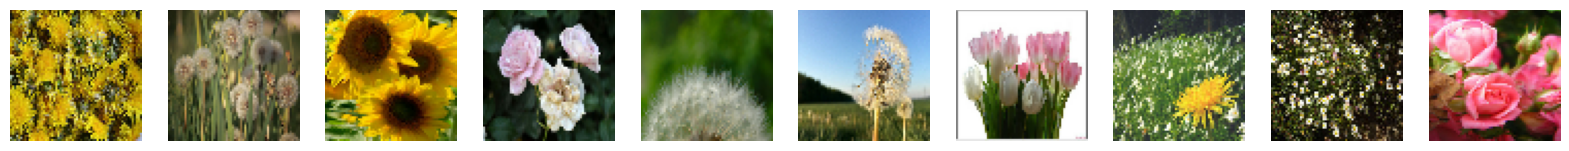

Reconstructions


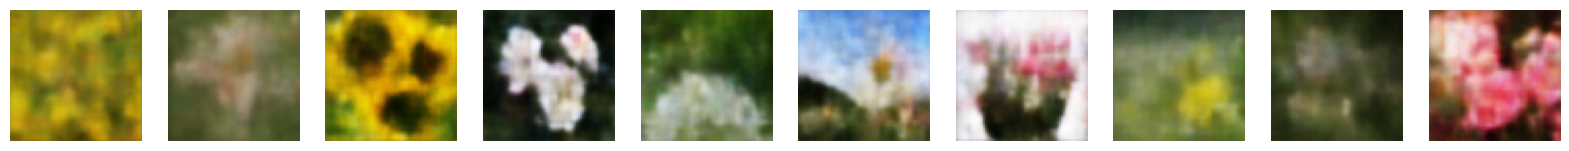

In [17]:
# Select a subset of the training set
batches_to_predict = 1
example_images = np.array(
    list(train_data.take(batches_to_predict).get_single_element())
)

# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("real Images")
display(example_images)
print("Reconstructions")
display(reconstructions)

## 4. Generating New Images

**Generating new images**
- Generate z_samples using *np.random.normal*, with sample size of grid_width * grid_height and **latent_dim = 50**
- Decoder the sampled points and save them in reconstructions for image display.

In [18]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

# Decode the sampled points
reconstructions = decoder.predict(z_sample)


1/1 [==============================] - 0s 113ms/step


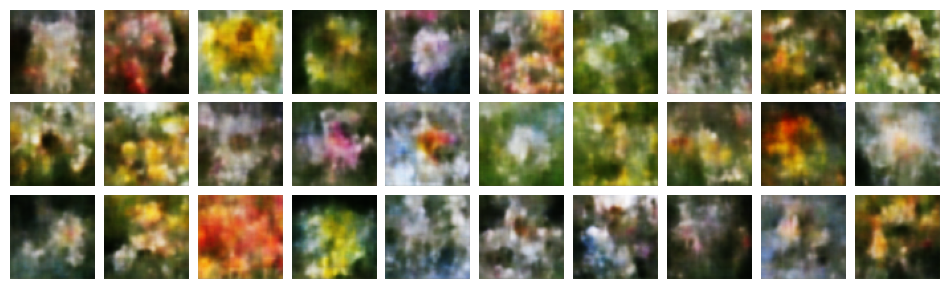

In [19]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(12, 3.5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :])